In [1]:
import pickle
from pathlib import Path

import getdist as gd
import getdist.plots as gdplots
import matplotlib.pyplot as plt
import numpy as np

from expconfig import load_config
from sampling.priors import CompoundPrior

In [2]:
OUTPUTS_PATH = Path().resolve().parent / "outputs"


def get_results_dir(n: int = 0) -> Path:
    """Get the most recent results directory.

    Parameters
    ----------
    n : int, optional
        Index of the results directory to retrieve.
        0 for the most recent, 1 for the second most recent, etc.
        Default is 0.

    Returns
    -------
    Path
        Path to the results directory.
    """
    output_dirs = sorted(
        OUTPUTS_PATH.iterdir(), key=lambda p: p.stat().st_mtime, reverse=True
    )
    return output_dirs[n]

In [3]:
RESULTS_DIR = get_results_dir(0)

cfg = load_config(RESULTS_DIR / "config.yaml")
prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(500_000, np.random.default_rng(1234))

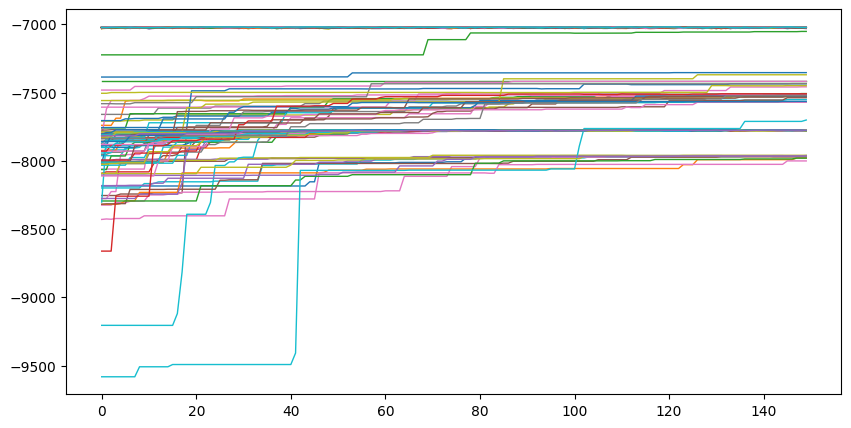

In [4]:
ln_prob = pickle.load(open(RESULTS_DIR / "lnprob_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers
)
samples = pickle.load(open(RESULTS_DIR / "samples_full.pkl", "rb")).reshape(
    -1, cfg.sampling.nwalkers, prior.n
)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

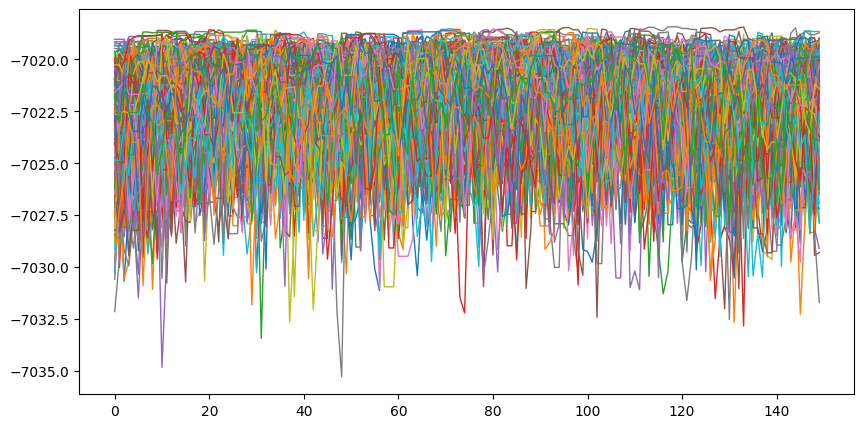

In [5]:
keep_mask = (ln_prob > -7100).all(axis=0)
ln_prob = ln_prob[:, keep_mask]
samples = samples[:, keep_mask, :]

with open(RESULTS_DIR / "lnprob.pkl", "wb") as f:
    pickle.dump(ln_prob.reshape(-1), f)
with open(RESULTS_DIR / "samples.pkl", "wb") as f:
    pickle.dump(samples.reshape(-1, prior.n), f)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob, lw=1)
plt.show()

Removed no burn in
Removed no burn in


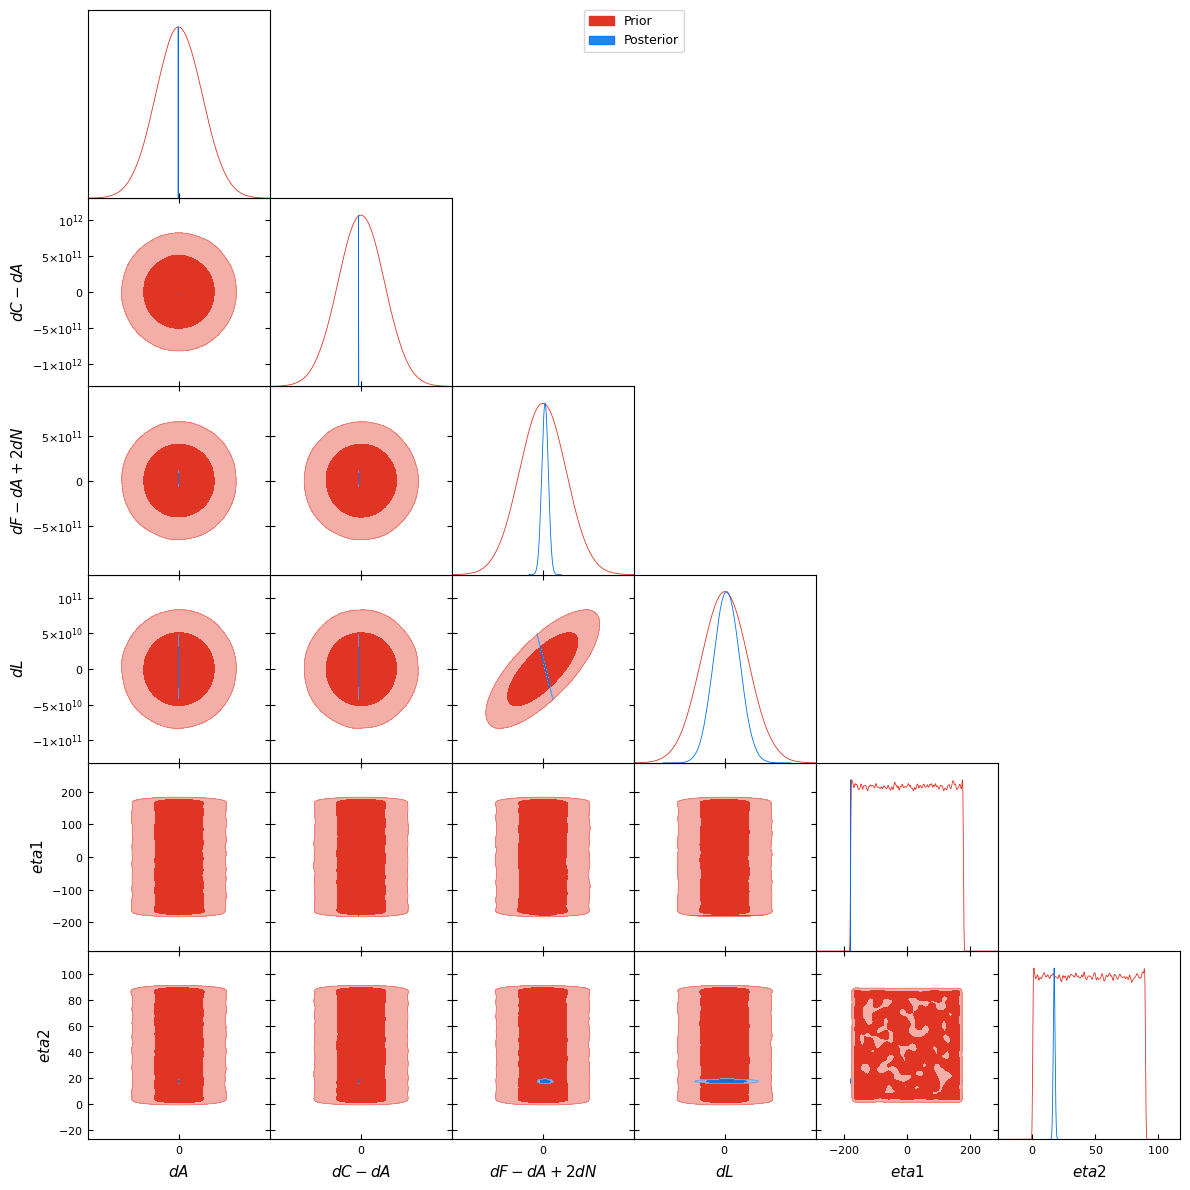

In [6]:
if prior.n == 7:
    names = ["dA", "dC-dA", "dF-dA+2dN", "dL", "dN-dL", "eta1", "eta2"]
elif prior.n == 6:
    names = ["dA", "dC-dA", "dF-dA+2dN", "dL", "eta1", "eta2"]
elif prior.n == 5:
    names = ["dA", "dC-dA", "dF-dA+2dN", "eta2", "eta21"]
else:
    raise ValueError(f"Unsupported number of parameters: {prior.n}")

posterior_samples_gd = gd.MCSamples(
    samples=samples.reshape(-1, prior.n), names=names, labels=names
)
prior_samples_gd = gd.MCSamples(samples=prior_samples, names=names, labels=names)
g = gdplots.getSubplotPlotter()
g.triangle_plot(
    [prior_samples_gd, posterior_samples_gd],
    legend_labels=["Prior", "Posterior"],
    filled=True,
)

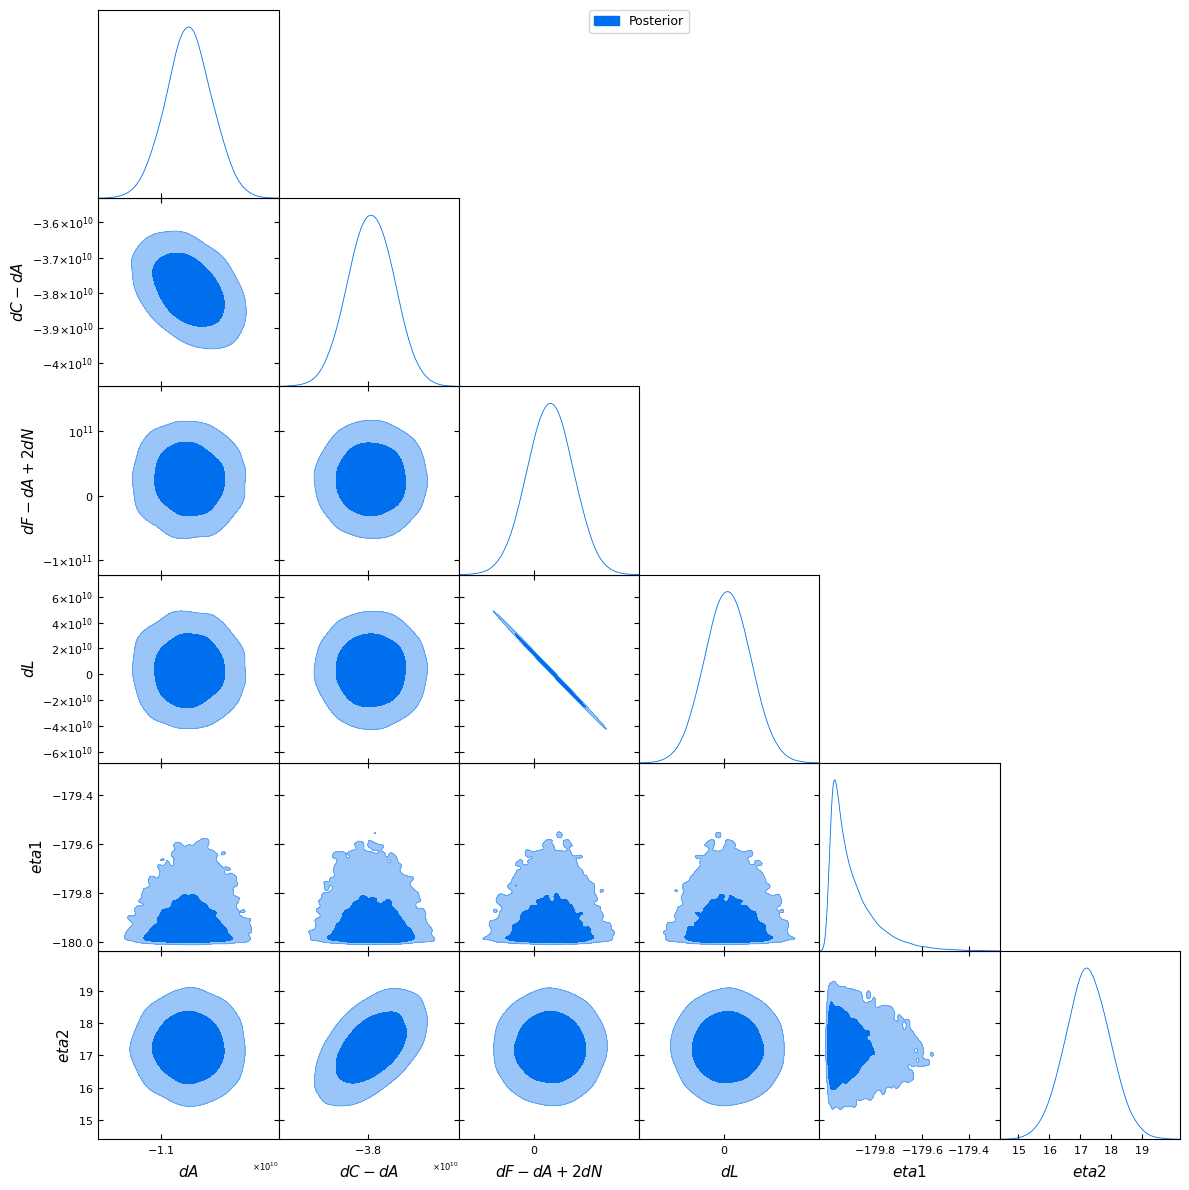

In [7]:
g.triangle_plot(
    [posterior_samples_gd],
    legend_labels=["Posterior"],
    filled=True,
)

In [8]:
from harmonic.model import RealNVPModel

from expconfig.config import RealNVPConfig, TrainConfig

model = RealNVPModel(prior.n, **RealNVPConfig(**cfg.realnvp.model_dump()).model_dump())
model.fit(
    posterior_samples_gd.samples,
    **TrainConfig(**cfg.training.model_dump()).model_dump(),
)

Training NF: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [9]:
posterior_samples = model.sample(10_000)
# should check that this looks like the marginals above. If I do stick with looking at posterior predictive distributions then should probably do this straight away and then plot the marginals based on these samples?

In [10]:
import pandas as pd

noise_levels: dict[str, float] = {
    "ab": 0.95,
    "bc": 0.63,
    "cd": 0.29,
    "df": 0.95,
}

DATA_FILE = Path().resolve().parent / "data" / "brett2024_ic_traveltimes.parquet"

df = pd.read_parquet(DATA_FILE)
ic_in = np.stack(df.in_location.values)
ic_out = np.stack(df.out_location.values)
dt_over_t = (df.delta_t / df.inner_core_travel_time).values

#  The noise levels for each reference phase are given in seconds, so we need to convert them to fractional traveltime perturbations by dividing by the inner core travel time.
# In principle this gives a different sigma for each observation.
sigma = (df["reference_phase"].map(noise_levels) / df["inner_core_travel_time"]).values

In [11]:
from icprem import PREM_IC_RHO, PREM_IC_VP
from tti.traveltimes import TravelTimeCalculator

if prior.n == 7:
    shear = True
    N = True
elif prior.n == 6:
    shear = True
    N = False
elif prior.n == 5:
    shear = False
    N = False

normalisation = -1 / (2 * PREM_IC_RHO * (PREM_IC_VP * 1e3) ** 2)
ttc = TravelTimeCalculator(
    ic_in, ic_out, normalisation=normalisation, nested=True, shear=shear, N=N
)

rng = np.random.default_rng(1234)

posterior_predictive = ttc(posterior_samples)
posterior_predictive += rng.normal(
    loc=0.0,
    scale=sigma,
    size=posterior_predictive.shape,
)

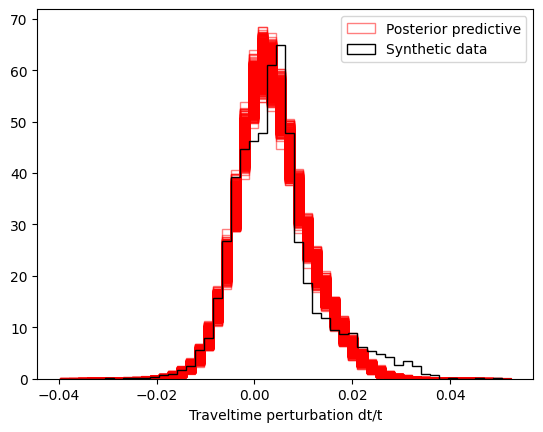

In [12]:
# ensuring that the histogram range is the same for both the posterior predictive and the synthetic data, so that densities are comparable
all_dists = np.vstack([posterior_predictive, dt_over_t[None, :]])
hist_range = (all_dists.min(), all_dists.max())
common_kwargs = {
    "bins": 50,
    "histtype": "step",
    "range": hist_range,
    "density": True,
}
plt.hist(
    posterior_predictive.T,
    **common_kwargs,
    label="Posterior predictive",
    color=np.full(posterior_predictive.shape[0], fill_value="r"),
    alpha=0.5,
)
plt.hist(
    dt_over_t,
    **common_kwargs,
    label="Synthetic data",
    color="k",
)
plt.xlabel("Traveltime perturbation dt/t")
plt.legend()